In [1]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install contextily

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import geopandas as gpd

In [5]:
# Read in travel data and add detail to locations that may be misinterpreted
df_travel = pd.read_csv('2019_transport_data.csv')
df_loc = df_travel[['Date', 'Departs']]
df_loc['Departs'].replace('[^a-zA-Z ]', '', regex=True, inplace=True)
df_loc = df_loc.dropna()
fixlocations = {"Cartagena": "Cartagena, Colombia", "Panama": "Panama City, Panama", 
                "San Jose": "San Jose, Costa Rica", "PDC": "Playa Del Carmen", 
                "Trinidad": "Trinidad, Cuba", "Bali": "Denpasar", "Jakarta day": "Jakarta", "Santiago": "Santiago, Chile"}
df_loc.replace(fixlocations, regex=True, inplace=True)

/Users/sophiefiler/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [6]:
pd.set_option('display.max_rows', 100)
df_loc

,Date,Departs
0,2019-03-01,London
1,2019-04-03,Buenos Aires
4,2019-04-06,Iguazu
7,2019-04-09,Mendoza
10,2019-04-12,"Santiago, Chile"
11,2019-04-13,Puerto Natales
12,2019-04-13,El Calafate
16,2019-04-17,El Chalten
20,2019-04-21,El Calafate
22,2019-04-23,Punta Arenas


In [7]:
# Find longitude and latitude of each location
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="world_map", timeout=10)
from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
df_loc['to_map'] = df_loc['Departs'].apply(geocode)
df_loc['latitude'] = df_loc['to_map'].apply(lambda x: x.latitude)
df_loc['longitude'] = df_loc['to_map'].apply(lambda x: x.longitude)

In [8]:
df_loc['geometry'] = gpd.points_from_xy(df_loc['longitude'], df_loc['latitude'])
df_loc = gpd.GeoDataFrame(df_loc)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

<AxesSubplot:>

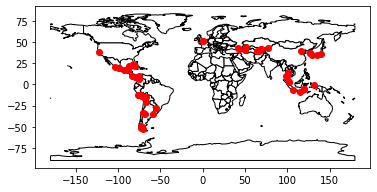

In [9]:
# Plot locations on map
ax = world.plot(color='white', edgecolor='black')
df_loc.plot(ax=ax, color='red')

In [10]:
import contextily as ctx
import shapely
from matplotlib.colors import to_hex
import seaborn as sns

/Users/sophiefiler/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


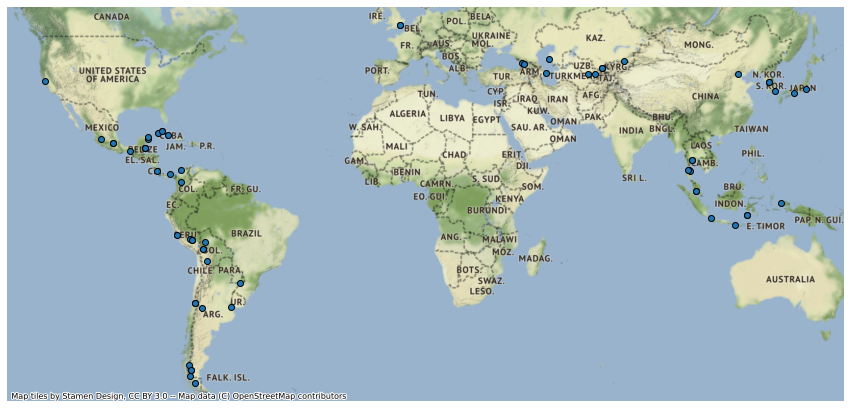

In [11]:
# Use a more detailed map
df_loc.crs = {'init': 'epsg:4326'}
df_loc = df_loc.to_crs(epsg=3857)
ax = df_loc.plot(figsize=(15, 15), alpha=1, edgecolor='k')
ctx.add_basemap(ax)
ax.set_axis_off()

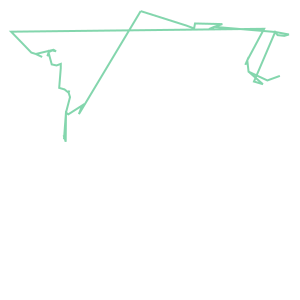

In [12]:
# Create lines to join the dots on the map
route = shapely.geometry.LineString(df_loc['geometry'].values)
display(route)

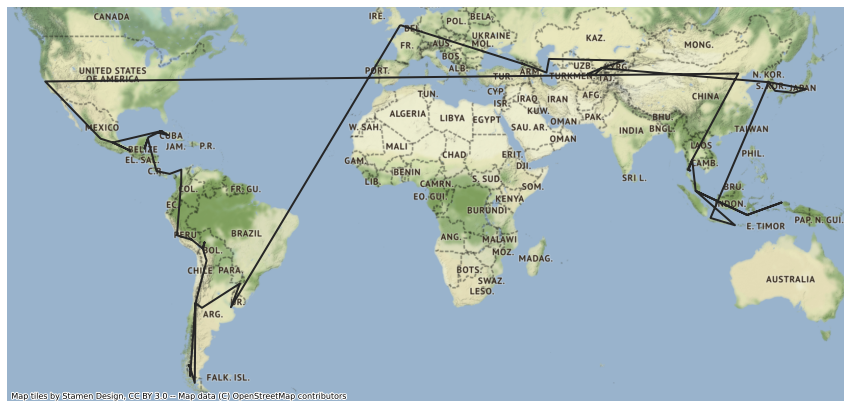

In [17]:
import matplotlib.pyplot as plt
df_route = gpd.GeoDataFrame({'geometry': [route], 'trip': ['world']})
# Make the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Choose line colour
c = to_hex(sns.dark_palette('black')[0])

# Plot lines of both trips
df_route.query('trip == "world"').plot(color=c, linewidth=2, ax=ax)

# Add basemap and remove axes
ctx.add_basemap(ax=ax)
ax.set_axis_off()

In [ ]:
# Route is correct but would look neater if the line travelled west out of San Francisco and joined to Beijing 
# from the East (as the flight did)

# Also, a point marker on London to clarify this is where my route started and ended